In [0]:
#!pip install autoimpute

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from mpl_toolkits.basemap import Basemap
import time

from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from autoimpute.imputations import SingleImputer, MultipleImputer
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from keras import optimizers
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras import backend as K

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

pd.plotting.register_matplotlib_converters()
#pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.3f}'.format
sns.set()

import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [0]:
def france_cluster_func(df):
  if df['location_cluster'] == 0 and df['Latitude_1'] <= 46:
    return 1000
  elif df['location_cluster'] == 0 and df['Latitude_1'] > 46:
    return 1001
  else:
    return df['location_cluster']

# Import Dataset

In [0]:
data = pd.read_csv(".../Fruits-Train_features.csv", encoding="latin1", na_values=['missing', 'Missing', 'MISSING'])

In [0]:
print(data.shape)
data.head(3)

(7720, 1029)


,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,feature 10,feature 11,feature 12,feature 13,feature 14,feature 15,feature 16,feature 17,feature 18,feature 19,feature 20,feature 21,feature 22,feature 23,feature 24,feature 25,feature 26,feature 27,feature 28,feature 29,feature 30,feature 31,feature 32,feature 33,feature 34,feature 35,feature 36,feature 37,feature 38,feature 39,feature 40,...,feature 990,feature 991,feature 992,feature 993,feature 994,feature 995,feature 996,feature 997,feature 998,feature 999,feature 1000,feature 1001,feature 1002,feature 1003,feature 1004,feature 1005,feature 1006,feature 1007,feature 1008,feature 1009,feature 1010,feature 1011,feature 1012,feature 1013,feature 1014,feature 1015,feature 1016,feature 1017,feature 1018,feature 1019,feature 1020,feature 1021,feature 1022,feature 1023,feature 1024,Date,Location,Latitude,Longitude,ClassId
0,0.000,6.098,0.000,0.976,1.395,0.000,0.000,6.696,0.014,0.000,0.000,0.000,9.352,0.000,0.000,3.484,0.000,0.057,0.000,13.402,0.000,0.007,0.297,1.133,0.478,0.459,1.634,0.960,5.719,12.347,0.000,1.197,0.236,0.000,0.000,4.324,0.000,0.000,0.000,5.204,...,0.000,0.000,0.000,0.000,1.328,0.000,0.000,0.000,11.304,0.989,0.000,44.524,0.000,0.000,0.000,0.000,0.000,0.000,3.092,0.000,0.000,0.000,0.000,0.000,4.209,0.000,0.000,0.000,0.000,0.000,0.000,0.072,0.000,36.450,0.000,7/18/11,Montbouy,47.866,2.828,2584
1,1.464,0.179,0.000,1.461,0.000,0.309,5.226,0.668,3.505,0.000,0.385,0.000,1.004,0.000,0.000,0.000,2.712,4.767,0.000,0.147,0.847,0.000,1.308,0.000,0.000,0.000,0.028,0.625,12.352,2.687,0.010,0.000,0.000,3.330,1.758,8.931,0.963,0.000,0.000,3.201,...,0.000,11.700,0.000,0.015,7.548,0.083,6.792,0.000,0.000,5.865,0.000,0.489,0.000,0.000,0.000,0.000,0.761,0.000,2.804,0.000,1.907,0.000,0.019,0.000,15.939,0.000,0.000,0.000,0.000,4.234,0.000,0.000,0.000,0.000,0.000,4/19/12,Portiragnes,nan,nan,14872
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.156,4.434,0.000,0.000,0.000,0.000,0.000,0.000,0.270,0.000,0.000,0.000,0.000,0.000,0.000,0.587,0.526,0.000,0.000,0.000,0.000,0.000,0.000,0.000,14.529,0.000,0.000,0.000,0.000,0.000,0.000,0.000,9.339,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.011,0.057,0.000,0.000,0.000,0.000,0.000,0.000,11/26/13,Montpellier,43.597,3.899,151


In [0]:
#Correct errors in date column & create month and year columns
data = data.replace("missing", np.nan).replace("1800-1-1", np.nan)\
                                                .replace("1074-7-20", "7/20/15")\
                                                .replace("1011-12-24", "12/24/15")
data["Date"] = pd.to_datetime(data.Date)
data["Month"] = data.Date.dt.month
data["Year"] = data.Date.dt.year
data["Quarter"] = data.Date.dt.quarter

In [0]:
data["Season"] = [(month % 12 + 3)//3 for month in data.Month]

In [0]:
data['Half_Year_1'] = [1 if x in [4,5,6,7,8,9,10] else 2 if x in [1,2,3,11,12] else np.nan for x in data.Month]
data['Half_Year_2'] = [1 if x in [5,6,7,8,9] else 2 if x in [1,2,3,4,10,11,12] else np.nan for x in data.Month]

# Missing Values

In [0]:
#Missing Values in Dataset
print(data.isna().sum().tail(10))
print('\nNumber of rows both Location & Latitude columns are missing:', len(data[(data.Location.isna()) & (data.Latitude.isna())]))
print('Total number of missing values in CNN features:', sum(data.iloc[:,:1024].isna().sum()))

Location        459
Latitude       4472
Longitude      4472
ClassId           0
Month           340
Year            340
Quarter         340
Season          340
Half_Year_1     340
Half_Year_2     340
dtype: int64

Number of rows both Location & Latitude columns are missing: 400
Total number of missing values in CNN features: 0


# Class ID Counts

ClassID Number: 755


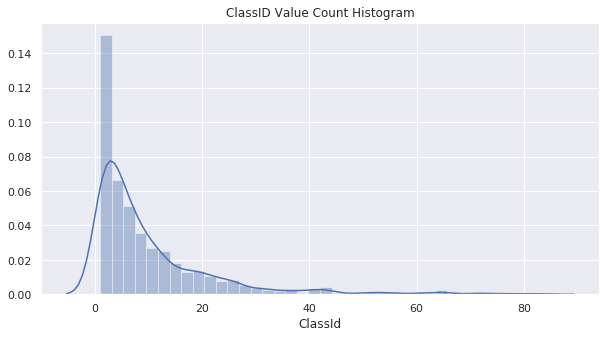

In [0]:
print('ClassID Number:', data.ClassId.nunique())

plt.figure(figsize=(10,5))
sns.distplot(data.ClassId.value_counts())
plt.title('ClassID Value Count Histogram')
plt.show()

# Filling Empty Coordinates

In [0]:
#Data collected from API is saved to csv file. No need to reuse the connection.
"""
location_data = traindata_location_modified_1[pd.isna(traindata_location_modified_1["Location_Modified"]) == False]["Location_Modified"]
location_data_unique = pd.DataFrame(location_data.unique())
location_data = location_data_unique[0].tolist()

coordinate_list4 = []
geolocator = Nominatim()
for i in range(1264):
  location = geolocator.geocode(location_data[i])
  try:
    coordinate_list4.append([location_data[i], location.latitude, location.longitude])
  except:
    coordinate_list4.append([location_data[i], "NaN", "NaN"])
  sleep(0.5)
"""

In [0]:
#Reading coordinates csv
coordinates = pd.read_csv(".../coordinates_final.csv", header=None,encoding="latin1")
coordinates.columns = ["Location", "Location_Modified", "Latitude_1", "Longitude_1"]
coordinates.drop(columns=["Location_Modified"], inplace = True)

In [0]:
data = data.merge(coordinates, how='left', on='Location')
data['Latitude_1'].fillna(data.Latitude, inplace=True)
data['Longitude_1'].fillna(data.Longitude, inplace=True)

In [0]:
data.isna().sum().tail(10)

Longitude      4472
ClassId           0
Month           340
Year            340
Quarter         340
Season          340
Half_Year_1     340
Half_Year_2     340
Latitude_1      408
Longitude_1     408
dtype: int64

# Coordinates on World Map

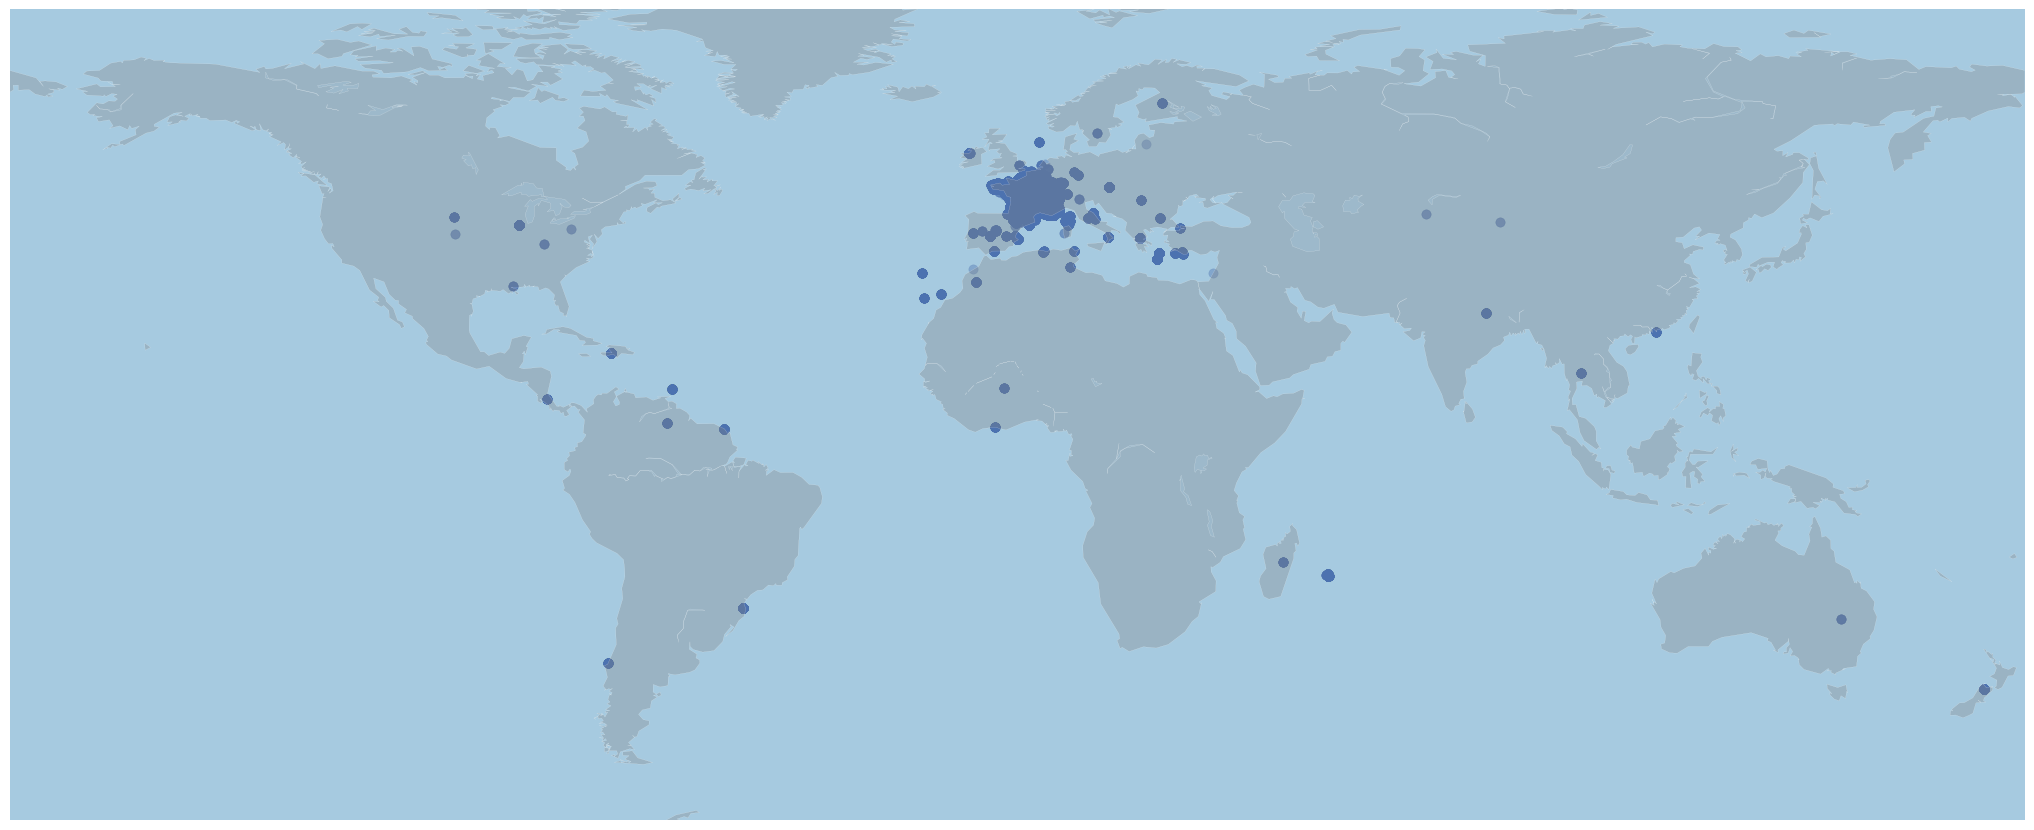

In [0]:
# Set the dimension of the figure
my_dpi=96
plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)
 
# Make the background map
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
 
# Add a point per position
m.scatter(data["Longitude_1"], data["Latitude_1"], alpha=0.4, cmap="Set1")
 
plt.show()

### Coordinates - France

In [0]:
#France App. Coordinates -> Latitude: 41.00 & 51.25 Longitude: -5.25 & 10
data_france = data[(data['Latitude_1'] >= 41) & (data['Latitude_1'] <= 51.25)]
data_france = data_france[(data_france['Longitude_1'] >= -5.25) & (data_france['Longitude_1'] <= 10)]
len(data_france)

6560

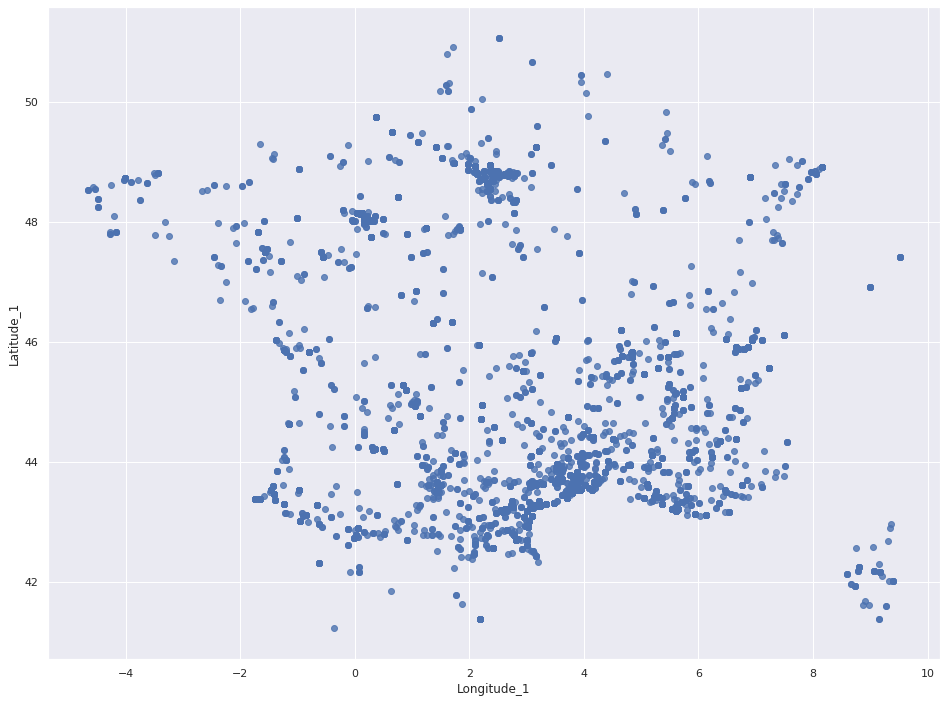

In [0]:
plt.figure(figsize=(16,12))
sns.regplot(x=data_france['Longitude_1'], y=data_france['Latitude_1'], fit_reg=False)

### ClassID Value Counts (out of France)

In [0]:
data_not_france = data[(data['Latitude_1'] < 41) | (data['Latitude_1'] > 51.25)]
data_not_france = data_not_france[(data_not_france['Longitude_1'] < -5.25) | (data_not_france['Longitude_1'] > 10)]
len(data_not_france)

467

In [0]:
data_not_france.ClassId.value_counts().value_counts()

1     43
2     15
4      9
3      5
7      5
5      4
6      3
28     2
8      1
59     1
10     1
16     1
18     1
21     1
22     1
25     1
26     1
9      1
Name: ClassId, dtype: int64

# Unique ClassId Counts by Month, Quarter, Season & Half Year

### Month

In [0]:
#ClassId count
main_list = []
for i in range(1,13):
    sub_list = list(data[data.Month == i]['ClassId'].unique())
    main_list.append(sub_list)

for i in range(12):
    print(len(main_list[i]))

45
53
105
197
272
267
263
276
253
194
105
75


In [0]:
#Count of ClassIds that occur in only one period
for i in range(12):
    period_list = main_list[i]
    other_period_list =[]
    for j in range(12):
        if i!=j:
            other_period_list = other_period_list + main_list[j]
    
    other_period_list = list(set(other_period_list))
    unique_cls_list = []
    for cls in period_list:
        if cls not in other_period_list:
            unique_cls_list.append(cls)
            
    print('Month', i+1, ':', len(unique_cls_list))

Month 1 : 0
Month 2 : 1
Month 3 : 10
Month 4 : 25
Month 5 : 25
Month 6 : 33
Month 7 : 28
Month 8 : 31
Month 9 : 23
Month 10 : 11
Month 11 : 6
Month 12 : 6


### Quarter

In [0]:
#ClassId count
main_list = []
for i in range(1,5):
    sub_list = list(data[data.Quarter == i]['ClassId'].unique())
    main_list.append(sub_list)

for i in range(4):
    print(len(main_list[i]))

148
468
497
270


In [0]:
#Count of ClassIds that occur in only one period
for i in range(4):
    period_list = main_list[i]
    other_period_list =[]
    for j in range(4):
        if i!=j:
            other_period_list = other_period_list + main_list[j]
    
    other_period_list = list(set(other_period_list))
    unique_cls_list = []
    for cls in period_list:
        if cls not in other_period_list:
            unique_cls_list.append(cls)
            
    print('Quarter', i+1, ':', len(unique_cls_list))

Quarter 1 : 13
Quarter 2 : 142
Quarter 3 : 135
Quarter 4 : 27


### Season

In [0]:
#ClassId count
main_list = []
for i in range(1,5):
    sub_list = list(data[data.Season == i]['ClassId'].unique())
    main_list.append(sub_list)

for i in range(4):
    print(len(main_list[i]))

124
383
521
371


In [0]:
#Count of ClassIds that occur in only one period
for i in range(4):
    period_list = main_list[i]
    other_period_list =[]
    for j in range(4):
        if i!=j:
            other_period_list = other_period_list + main_list[j]
    
    other_period_list = list(set(other_period_list))
    unique_cls_list = []
    for cls in period_list:
        if cls not in other_period_list:
            unique_cls_list.append(cls)
            
    print('Season', i+1, ':', len(unique_cls_list))

Season 1 : 7
Season 2 : 96
Season 3 : 141
Season 4 : 53


### Half Year 1

In [0]:
#ClassId count
main_list = []
for i in range(1,3):
    sub_list = list(data[data.Half_Year_1 == i]['ClassId'].unique())
    main_list.append(sub_list)

for i in range(2):
    print(len(main_list[i]))

711
234


In [0]:
#Count of ClassIds that occur in only one period
for i in range(2):
    period_list = main_list[i]
    other_period_list =[]
    for j in range(2):
        if i!=j:
            other_period_list = other_period_list + main_list[j]
    
    other_period_list = list(set(other_period_list))
    unique_cls_list = []
    for cls in period_list:
        if cls not in other_period_list:
            unique_cls_list.append(cls)
            
    print('Half_Year_1', i+1, ':', len(unique_cls_list))

Half_Year_1 1 : 507
Half_Year_1 2 : 30


### Half Year 2

In [0]:
#ClassId count
main_list = []
for i in range(1,3):
    sub_list = list(data[data.Half_Year_2 == i]['ClassId'].unique())
    main_list.append(sub_list)

for i in range(2):
    print(len(main_list[i]))

661
433


In [0]:
#Count of ClassIds that occur in only one period
for i in range(2):
    period_list = main_list[i]
    other_period_list =[]
    for j in range(2):
        if i!=j:
            other_period_list = other_period_list + main_list[j]
    
    other_period_list = list(set(other_period_list))
    unique_cls_list = []
    for cls in period_list:
        if cls not in other_period_list:
            unique_cls_list.append(cls)
            
    print('Half_Year_2', i+1, ':', len(unique_cls_list))

Half_Year_2 1 : 308
Half_Year_2 2 : 80


# Location Clustering Test - DBSCAN

### Optimal Epsilon Value

In [0]:
data2 = data[data.Latitude_1.isna() == False]

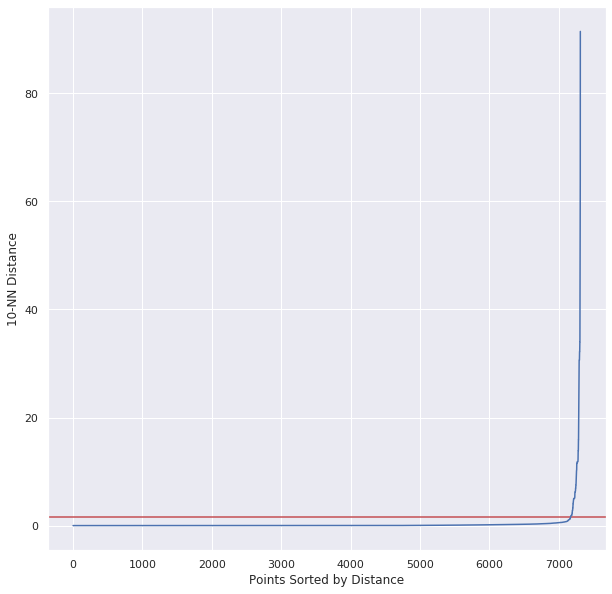

In [0]:
#Epsilon selection for DBSCAN
nn = 10
knn = NearestNeighbors(n_neighbors=nn, metric = "euclidean")
knn.fit(data2[['Latitude_1', 'Longitude_1']])
distances, indices = knn.kneighbors(data2[['Latitude_1', 'Longitude_1']])
distanceDec = sorted(distances[:,nn-1])

plt.figure(figsize=(10, 10))
plt.ylabel("10-NN Distance")
plt.xlabel("Points Sorted by Distance")
plt.axhline(y=1.5, color='r')
plt.plot(list(range(1, len(data2)+1)), distanceDec)

### DBSCAN Model

In [0]:
dbscan = DBSCAN(eps=1.5, min_samples=10).fit(data2[['Latitude_1', 'Longitude_1']])

data2['location_cluster'] = dbscan.labels_
data2['location_cluster'].value_counts()

 0     6499
 1      228
-1      138
 4       89
 3       83
 11      55
 6       53
 2       44
 10      41
 5       35
 8       22
 7       13
 9       12
Name: location_cluster, dtype: int64

In [0]:
data2['location_cluster_2'] = data2.apply(france_cluster_func, axis=1)

In [0]:
#DBSCAN Clusters
main_list = []
for i in data2['location_cluster_2'].unique():
    sub_list = list(data2[data2.location_cluster_2 == i]['ClassId'].unique())
    main_list.append(sub_list)

for i in range(len(data2['location_cluster_2'].unique())):
    print('Cluster', list(data2['location_cluster_2'].unique())[i], ':', len(main_list[i]))

Cluster 1001 : 426
Cluster 1000 : 632
Cluster 1 : 12
Cluster -1 : 81
Cluster 2 : 15
Cluster 3 : 26
Cluster 4 : 8
Cluster 5 : 7
Cluster 6 : 27
Cluster 7 : 5
Cluster 8 : 7
Cluster 9 : 6
Cluster 10 : 7
Cluster 11 : 20


In [0]:
for i in range(len(data2['location_cluster_2'].unique())):
    cluster_list = main_list[i]
    other_cluster_list =[]
    for j in range(len(data2['location_cluster_2'].unique())):
        if i!=j:
            other_cluster_list = other_cluster_list + main_list[j]

    other_cluster_list = list(set(other_cluster_list))
    unique_cls_list = []
    for cls in cluster_list:
        if cls not in other_cluster_list:
            unique_cls_list.append(cls)
            
    print('Cluster', list(data2['location_cluster_2'].unique())[i], ':', len(unique_cls_list))

Cluster -3 : 81
Cluster -2 : 232
Cluster 1 : 1
Cluster -1 : 7
Cluster 2 : 0
Cluster 3 : 3
Cluster 4 : 1
Cluster 5 : 1
Cluster 6 : 1
Cluster 7 : 0
Cluster 8 : 0
Cluster 9 : 0
Cluster 10 : 0
Cluster 11 : 0


### Location Cluster Prediction with known Latitude & Longitude information

#### Logistic Regression

In [0]:
data2['location_cluster_2'] = pd.Categorical(data2['location_cluster_2'])

In [0]:
lg = LogisticRegression()
print(cross_val_score(lg, data2[['Latitude_1', 'Longitude_1']], data2['location_cluster_2'], cv=5, scoring='accuracy'))  

[0.85753238 0.86766712 0.88456284 0.86908842 0.86813187]


#### KNN

In [0]:
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler((0, 1))),
        ("classifier", KNeighborsClassifier())
    ]
)

parameters = {
    "classifier__n_neighbors": [1, 3, 5, 7]
}

grid_search = GridSearchCV(pipeline, param_grid=parameters, scoring = 'accuracy', cv=5)
grid_search.fit(data2[['Latitude_1', 'Longitude_1']], data2['location_cluster_2'])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('classifier',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param

In [0]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'classifier__n_neighbors': 1}
0.999042669584245


# Imputation Model Tests

### Prediction Model Tests for Missing Location Values

#### Logistic Regression

In [0]:
data2['location_cluster_2'] = pd.Categorical(data2['location_cluster_2'])

In [0]:
lg = LogisticRegression()
print(cross_val_score(lg, data2.iloc[:,:1024], data2['location_cluster_2'], cv=5, scoring='accuracy'))  

[0.67075665 0.70463847 0.67964481 0.66895134 0.68200549]


#### KNN

In [0]:
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler((0, 1))),
        ("classifier", KNeighborsClassifier())
    ]
)

parameters = {
    "classifier__n_neighbors": [3, 5, 7]
}

grid_search = GridSearchCV(pipeline, param_grid=parameters, scoring = 'accuracy', cv=5)
grid_search.fit(data2.iloc[:,:1024], data2['location_cluster_2'])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('classifier',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param

In [0]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'classifier__n_neighbors': 3}
0.7357768052516411


#### Random Forest

In [0]:
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler((0, 1))),
        ("classifier", RandomForestClassifier())
    ]
)

parameters = {
    "classifier__max_depth": [2, 3, 5],
    "classifier__n_estimators": [25, 50, 100]
}

grid_search = GridSearchCV(pipeline, param_grid=parameters, scoring = 'accuracy', cv=5)
grid_search.fit(data2.iloc[:,:1024], data2['location_cluster_2'])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('classifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_spl

In [0]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'classifier__max_depth': 5, 'classifier__n_estimators': 25}
0.6237691466083151


### Prediction Model Tests for Missing Month Values

In [0]:
data2 = data2[data2.Month.isna() == False]

In [0]:
data2['Month'] = pd.Categorical(data2['Month'])

#### KNN

In [0]:
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler((0, 1))),
        ("classifier", KNeighborsClassifier())
    ]
)

parameters = {
    "classifier__n_neighbors": [3, 5, 7]
}

grid_search = GridSearchCV(pipeline, param_grid=parameters, scoring = 'accuracy', cv=5)
grid_search.fit(data2.iloc[:,:1024], data2['Month'])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('classifier',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param

In [0]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'classifier__n_neighbors': 3}
0.5156486970908589


#### Random Forest

In [0]:
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler((0, 1))),
        ("classifier", RandomForestClassifier())
    ]
)

parameters = {
    "classifier__max_depth": [3, 5],
    "classifier__n_estimators": [50, 100]
}

grid_search = GridSearchCV(pipeline, param_grid=parameters, scoring = 'accuracy', cv=5)
grid_search.fit(data2.iloc[:,:1024], data2['Month'])

In [0]:
print(grid_search.best_params_)
print(grid_search.best_score_)

### Prediction Model Tests for Missing Season Values

#### KNN

In [0]:
data2['Season'] = pd.Categorical(data2['Season'])

In [0]:
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler((0, 1))),
        ("classifier", KNeighborsClassifier())
    ]
)

parameters = {
    "classifier__n_neighbors": [3, 5, 7]
}

grid_search = GridSearchCV(pipeline, param_grid=parameters, scoring = 'accuracy', cv=5)
grid_search.fit(data2.iloc[:,:1024], data2['Season'])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('classifier',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param

In [0]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'classifier__n_neighbors': 3}
0.6765476354611885


#### Random Forest

In [0]:
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler((0, 1))),
        ("classifier", RandomForestClassifier())
    ]
)

parameters = {
    "classifier__max_depth": [3, 5],
    "classifier__n_estimators": [50, 100]
}

grid_search = GridSearchCV(pipeline, param_grid=parameters, scoring = 'accuracy', cv=5)
grid_search.fit(data2.iloc[:,:1024], data2['Season'])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('classifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_spl

In [0]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'classifier__max_depth': 5, 'classifier__n_estimators': 100}
0.4912450020681097


# Training Test Split

In [0]:
data2 = data.drop(['Date', 'Location', 'Latitude', 'Longitude', 'Year', 'Quarter', 'Season', 'Half_Year_1', 'Half_Year_2'], axis=1)
data2['Month'] = pd.Categorical(data2['Month'])

In [0]:
exclude_list = list(data2.ClassId.value_counts()[data2.ClassId.value_counts() <= 2].index)

In [0]:
data3 = data2[data2.ClassId.isin(exclude_list) == False]
data4 = data2[data2.ClassId.isin(exclude_list)]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data3.drop('ClassId', axis=1), data3.ClassId, test_size=0.20, random_state=23, shuffle=True, stratify=data3.ClassId)

# Model Training - ANN

### Preprocessing of Training and Validation Sets with StratifiedKFold

In [0]:
start_time = time.time()
s_k_fold = StratifiedKFold(n_splits = 5)

dataset_dict = {}
count=0
for train_index, test_index in s_k_fold.split(X_train, y_train):
  count+=1

  #Train & Validation split by StratifiedKFold
  X_train_fold = X_train.iloc[train_index]
  y_train_fold = y_train.iloc[train_index]

  X_test_fold = X_train.iloc[test_index]
  y_test_fold = y_train.iloc[test_index]

  X_train_fold = pd.concat([X_train_fold, data4.drop('ClassId', axis=1)], axis=0)
  y_train_fold = pd.concat([y_train_fold, data4.ClassId], axis=0)


  #Location Clustering
  X_train_fold2 = X_train_fold[X_train_fold.Latitude_1.isna() == False]

  dbscan = DBSCAN(eps=1.5, min_samples=10).fit(X_train_fold2[['Latitude_1', 'Longitude_1']])
  X_train_fold2['location_cluster'] = dbscan.labels_
  X_train_fold2['location_cluster_2'] = X_train_fold2.apply(france_cluster_func, axis=1)
  X_train_fold2['location_cluster_2'].replace(-1,1002, inplace=True)

  X_train_fold = X_train_fold.drop(['Latitude_1', 'Longitude_1'], axis=1).join(X_train_fold2[['location_cluster_2']], how='left')


  #MultipleImputer with Logistic Regression
  X_train_fold['Month'] = pd.Categorical(X_train_fold['Month'])
  X_train_fold['location_cluster_2'] = pd.Categorical(X_train_fold['location_cluster_2'])

  imputer = MultipleImputer(
      n=1,
      strategy={"Month": "multinomial logistic", "location_cluster_2": "multinomial logistic"},
      predictors={"Month": "all", "location_cluster_2": "all"},
      return_list=True
  )

  X_train_imputed = imputer.fit_transform(X_train_fold)[0][1]


  #One Hot Encoder
  enc = OneHotEncoder(handle_unknown='ignore', categorical_features=[1024,1025], sparse=False)
  X_train_enc = enc.fit_transform(X_train_imputed)


  #Normalization
  sc = MinMaxScaler((0,1))
  X_train_sc = sc.fit_transform(X_train_enc)


  #Oversampling
  ovsamp = RandomOverSampler(random_state=23)
  X_train_res, y_train_res = ovsamp.fit_resample(X_train_sc, y_train_fold)


  #Validation Set Preprocessing
  knn = KNeighborsClassifier(n_neighbors=1) #Location Cluster Prediction for samples with latitude & longitude values
  knn.fit(X_train_fold2[['Latitude_1', 'Longitude_1']], X_train_fold2['location_cluster_2'])
  X_test_fold2 = X_test_fold[X_test_fold.Latitude_1.isna() == False]
  X_test_fold2['location_cluster'] = knn.predict(X_test_fold2[['Latitude_1', 'Longitude_1']])
  X_test_fold2['location_cluster_2'] = X_test_fold2.apply(france_cluster_func, axis=1)
  X_test_fold = X_test_fold.drop(['Latitude_1', 'Longitude_1'], axis=1).join(X_test_fold2[['location_cluster_2']], how='left')

  X_test_fold['Month'] = pd.Categorical(X_test_fold['Month']) #Imputation
  X_test_fold['location_cluster_2'] = pd.Categorical(X_test_fold['location_cluster_2'])
  X_test_imputed = imputer.transform(X_test_fold)[0][1]

  X_test_enc = enc.transform(X_test_imputed) #One Hot Encoding

  X_test_sc = sc.transform(X_test_enc) #Normalization

  #Label Preprocessing for Keras
  lenc = LabelEncoder()
  lenc.fit(y_train_res)
  y_train_lenc = lenc.transform(y_train_res)
  #y_train_lenc = np_utils.to_categorical(y_train_lenc, num_classes=755)
  y_test_lenc = lenc.transform(y_test_fold)
  #y_test_lenc = np_utils.to_categorical(y_test_lenc, num_classes=755)

  dataset_dict['X_traning_'+str(count)] = X_train_res
  dataset_dict['y_traning_'+str(count)] = y_train_lenc
  dataset_dict['X_valid_'+str(count)] = X_test_sc
  dataset_dict['y_valid_'+str(count)] = y_test_lenc

  print(count)
print(time.time() - start_time)

### Cross Validation & Hyperparameter Tuning

In [0]:
# hidden layer size, kernel regularization, dropout
valid_result_df = pd.DataFrame(columns=['optimizer','learning_rate','batch_size','epoch','hidden_layers', 'regularization', 'dropout_rate', 'valid_acc_score'])
n_batch_size = 32
n_epochs = 500
count = 0
start_time = time.time()
for layer in [(),128, 512, 800, 900, 1024, 1450, 2048]:
  for lr in [0.01, 0.001]:
    for reg in [0, 0.01, 0.001]:
      for drop in [0, 0.2, 0.5]:
        count += 1
        acc_scores = []
        for cv_set in range(1,6):
          X_train_cv = dataset_dict['X_traning_'+str(cv_set)]
          y_train_cv = dataset_dict['y_traning_'+str(cv_set)]
          X_valid_cv = dataset_dict['X_valid_'+str(cv_set)]
          y_valid_cv = dataset_dict['y_valid_'+str(cv_set)]

          #Model
          K.clear_session()
          model = Sequential()

          if layer == ():
            model.add(Dense(len(set(y_train_cv)), kernel_initializer = 'uniform', activation='softmax', input_dim = len(X_train_cv[0])))
          else:
            if reg != 0:
              model.add(Dense(units = layer, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(X_train_cv[0]), kernel_regularizer=regularizers.l2(reg)))
              model.add(Dropout(drop))
            else:
              model.add(Dense(units = layer, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(X_train_cv[0])))
              model.add(Dropout(drop))

            model.add(Dense(len(set(y_train_cv)), activation='softmax'))

          optimizer = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
          model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

          y_train_cv2 = np_utils.to_categorical(y_train_cv, num_classes=755)
          y_valid_cv2 = np_utils.to_categorical(y_valid_cv, num_classes=755)

          es = EarlyStopping(monitor='val_acc', verbose=0, patience=5,  min_delta=1)
          model.fit(X_train_cv, y_train_cv2, batch_size = n_batch_size, epochs = n_epochs, validation_data=(X_valid_cv,y_valid_cv2), verbose = 0, callbacks=[es])

          y_pred = model.predict_classes(X_valid_cv)
          model_score_test = accuracy_score(y_valid_cv, y_pred)
          acc_scores.append(model_score_test)

        valid_result_df.loc[len(valid_result_df)] = ['adam', lr, n_batch_size, n_epochs,layer, reg, drop, np.mean(acc_scores)]

        print(count)
        if count % 10 == 0:

          print(time.time() - start_time)
          print(valid_result_df[['learning_rate','hidden_layers', 'regularization', 'dropout_rate', 'valid_acc_score']].sort_values('valid_acc_score', ascending=False).head(5))


In [0]:
pd.options.display.float_format = '{:,.3f}'.format
valid_result_df.sort_values('valid_acc_score', ascending=False).head(5)

### Final Test on Test Data

In [0]:
X_train = pd.concat([X_train, data4.drop('ClassId', axis=1)], axis=0)
y_train = pd.concat([y_train, data4.ClassId], axis=0)

In [0]:
#Preprocessing

#Location Clustering
X_train2 = X_train[X_train.Latitude_1.isna() == False]

dbscan = DBSCAN(eps=1.5, min_samples=10).fit(X_train2[['Latitude_1', 'Longitude_1']])
X_train2['location_cluster'] = dbscan.labels_
X_train2['location_cluster_2'] = X_train2.apply(france_cluster_func, axis=1)
X_train2['location_cluster_2'].replace(-1,1002, inplace=True)

X_train = X_train.drop(['Latitude_1', 'Longitude_1'], axis=1).join(X_train2[['location_cluster_2']], how='left')

#MultipleImputer with Logistic Regression
X_train['Month'] = pd.Categorical(X_train['Month'])
X_train['location_cluster_2'] = pd.Categorical(X_train['location_cluster_2'])

imputer = MultipleImputer(
    n=1,
    strategy={"Month": "multinomial logistic", "location_cluster_2": "multinomial logistic"},
    predictors={"Month": "all", "location_cluster_2": "all"},
    return_list=True
)

X_train_imputed = imputer.fit_transform(X_train)[0][1]

#One Hot Encoder
enc = OneHotEncoder(handle_unknown='ignore', categorical_features=[1024,1025], sparse=False)
X_train_enc = enc.fit_transform(X_train_imputed)

#Normalization
sc = MinMaxScaler((0,1))
X_train_sc = sc.fit_transform(X_train_enc)

#Oversampling
ovsamp = RandomOverSampler(random_state=23)
X_train_res, y_train_res = ovsamp.fit_resample(X_train_sc, y_train)

#Test Set Preprocessing
knn = KNeighborsClassifier(n_neighbors=1) #Location Cluster Prediction for samples with latitude & longitude values
knn.fit(X_train2[['Latitude_1', 'Longitude_1']], X_train2['location_cluster_2'])
X_test2 = X_test[X_test.Latitude_1.isna() == False]
X_test2['location_cluster'] = knn.predict(X_test2[['Latitude_1', 'Longitude_1']])
X_test2['location_cluster_2'] = X_test2.apply(france_cluster_func, axis=1)
X_test = X_test.drop(['Latitude_1', 'Longitude_1'], axis=1).join(X_test2[['location_cluster_2']], how='left')

X_test['Month'] = pd.Categorical(X_test['Month']) #Imputation
X_test['location_cluster_2'] = pd.Categorical(X_test['location_cluster_2'])
X_test_imputed = imputer.transform(X_test)[0][1]

X_test_enc = enc.transform(X_test_imputed) #One Hot Encoding

X_test_sc = sc.transform(X_test_enc) #Normalization

#Label Preprocessing for Keras

lenc = LabelEncoder()
lenc.fit(y_train_res)
y_train_lenc = lenc.transform(y_train_res)
y_test_lenc = lenc.transform(y_test)

In [0]:
#Model
n_batch_size = 32
n_epochs = 500
patience = 10
min_delta = 1

K.clear_session()
model = Sequential()

model.add(Dense(755, kernel_initializer = 'uniform', activation='softmax', input_dim = 1049))

optimizer = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

y_train_lenc2 = np_utils.to_categorical(y_train_lenc, num_classes=755)
y_test_lenc2 = np_utils.to_categorical(y_test_lenc, num_classes=755)

es = EarlyStopping(monitor='val_acc', verbose=1, patience=patience,  min_delta=min_delta)
model.fit(X_train_res, y_train_lenc2, batch_size = n_batch_size, epochs = n_epochs, validation_data=(X_test_sc,y_test_lenc2), verbose = 1, callbacks=[es])

Train on 49830 samples, validate on 1494 samples
Epoch 1/500
49830/49830 [==============================] - 7s 148us/step - loss: 0.4186 - acc: 0.9351 - val_loss: 0.7701 - val_acc: 0.8300
Epoch 2/500
49830/49830 [==============================] - 7s 146us/step - loss: 0.0051 - acc: 0.9998 - val_loss: 0.7362 - val_acc: 0.8367
Epoch 3/500
49830/49830 [==============================] - 7s 145us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.7403 - val_acc: 0.8373
Epoch 4/500
49830/49830 [==============================] - 7s 144us/step - loss: 6.7839e-04 - acc: 1.0000 - val_loss: 0.7486 - val_acc: 0.8367
Epoch 5/500
49830/49830 [==============================] - 7s 148us/step - loss: 3.2202e-04 - acc: 1.0000 - val_loss: 0.7560 - val_acc: 0.8407
Epoch 6/500
49830/49830 [==============================] - 7s 148us/step - loss: 1.5423e-04 - acc: 1.0000 - val_loss: 0.7682 - val_acc: 0.8380
Epoch 7/500
49830/49830 [==============================] - 7s 145us/step - loss: 7.6052e-05 - acc: 1.0000

In [0]:
y_pred = model.predict_classes(X_test_sc)
model_score_test = accuracy_score(y_test_lenc, y_pred)
print('Accuracy Score on Final Test: {:,.2f}%'.format(model_score_test * 100))

Accuracy Score on Final Test: 84.27%
